<h1><center>Obliczenia ewolucyjne</center></h1>
<h3><center><ul style="list-style: none;">
    <li>Jakub Kurek 234078</li>
    <li>Mateusz Gałasiński 234054</li>
    </ul></center></h3> 
<h2><center>Zadanie 3 - Optymalizacja z wykorzystaniem wzorca</center></h2>

## Instalacja zależności

In [1]:
!pip install deap > /dev/null
!pip install matplotlib > /dev/null
!pip install tabulate > /dev/null
%matplotlib notebook

## Obsługa konfiguracji oraz import bibliotek

### Imports

In [2]:
from tabulate import tabulate
from IPython.display import display, HTML
import itertools
import math
import operator
import random
from statistics import mean
import time

import numpy
np = numpy
from deap import base
from deap import benchmarks #import rosenbrock, griewank, ackley, schwefel, schaffer
from deap import creator
from deap import tools

#plots
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from functools import reduce
#random
from numpy import random as nrand
nrand.seed(0)
from random import seed
seed(0)
#constants
COLUMN_HIGHLIGHT='#9AD10F'

<div>Setting styles</div>
<style>
div.ui-dialog-titlebar.ui-widget-header {display: none;}
</style>
<style>
div.ui-dialog-titlebar {display: none;}
</style>

In [3]:
HTML("<style>div.inline {display: inline-block; padding: 0;}</style>")

In [208]:
from pathlib import Path
import json

class Config(object): 
    def __init__(self, TYPE, MIN_COORD, MAX_COORD, FUNCTION, CHI, C, P, BOA_C, BOA_A, DIST, DIMS, NSWARMS, NPARTICLES, NEXCESS, RCLOUD, EVALS):
        self.CHI = CHI        
        self.TYPE = TYPE
        self.MIN_COORD = MIN_COORD
        self.MAX_COORD = MAX_COORD
        self.FUNCTION = FUNCTION
        self.C = C
        self.P = P
        self.BOA_C = BOA_C
        self.BOA_A = BOA_A
        self.DIST = DIST
        self.DIMS = DIMS
        self.NSWARMS = NSWARMS
        self.NPARTICLES = NPARTICLES
        self.NEXCESS = NEXCESS
        self.RCLOUD = RCLOUD
        self.EVALS = EVALS

def as_config(dct):
    return Config(
        dct['TYPE'],
        dct['MIN_COORD'], 
        dct['MAX_COORD'], 
        dct['FUNCTION'], 
        dct['CHI'],
        dct['C'],
        dct['P'],
        dct['BOA_C'],
        dct['BOA_A'],
        dct['DIST'],
        dct['DIMS'],
        dct['NSWARMS'],
        dct['NPARTICLES'], 
        dct['NEXCESS'], 
        dct['RCLOUD'],
        dct['EVALS'],
        )

load_config = lambda : json.loads(json_config, object_hook = as_config)

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

colorize = lambda text, patterns: reduce(lambda a,b: a.replace(b, cstr(b, color=COLUMN_HIGHLIGHT)) , patterns, text)
colorize_column = lambda table, col_name: colorize(table, [col_name])
def tabulate_config(col_name=None):
    table = tabulate([[cfg.TYPE, cfg.MIN_COORD, cfg.MAX_COORD, cfg.FUNCTION, cfg.CHI, cfg.TYPE, cfg.C, cfg.P, cfg.DIST, cfg.DIMS, cfg.NSWARMS, cfg.NPARTICLES, cfg.NEXCESS, cfg.RCLOUD, cfg.BOA_C, cfg.BOA_A]],
                     headers=["TYPE", "MIN_COORD", "MAX_COORD", "FUNCTION", "CHI", "TYPE", "C", "P", "DIST", "DIMS", "NSWARMS", "NPARTICLES", "NEXCESS", "RCLOUD", "BOA_C", "BOA_A"],
                     tablefmt="html")
    if col_name:
        display(HTML(colorize_column(table, col_name)))
    else:
        display(HTML(table))

# Algorytmy MPSO, MSPSO oraz BOA

<div style="text-align: justify">
Implementacja algorytmów odbyła się z wykorzstaniem biblioteki DEAP dla języka Python
<h4>MPSO</h4>
Skorzystano z opisu algorytmu MPSO, opublikowanego w <a href="https://www.researchgate.net/profile/Xiaodong_Li14/publication/226962021_Particle_Swarms_for_Dynamic_Optimization_Problems/links/564c4dc508ae3374e5de839b/Particle-Swarms-for-Dynamic-Optimization-Problems.pdf">"Particle_Swarms_for_Dynamic_Optimization_Problem"</a>. W algorytmie tym, aktualizacja położenia poszczególnych cząsteczek odbywa się według tej samej formuły co w algorytmie PSO, jednakże zachodzi jedynie w obrębie subrojów.
Algorytm uwzględnia również szereg mechanizmów mających na celu pokonanie trudności wynikających z dynamicznego środowiska.
<h4>BOA</h4>
Pełny opis oryginalnego algorytmu BOA znajdue się w <a href="https://ftims.edu.p.lodz.pl/pluginfile.php/140849/mod_resource/content/1/BOA.pdf">"Butterfly optimization algorithm: a novel approach for global optimization"</a>. Od klasycznego PSO odróżnia się zastosowaniem operatora lokalnego przeszukiwania oraz innej formuły aktualizacji położenia cząstek, inspirowanej ruchami motyli. Opiera się ona o wykorzystanie informacji o "zapachu" (ang. <i>fragrance</i>) danego motyla, która wpływa na poruszanie się cząstki w taki sposób, aby cząstki, które znajdują się w rozwiązaniach o wyższej wartości funkcji przystosowania, miały większy wpływ na przeszukiwane obszary. Wysokość współczynnika zapachu zależy od stałego mnożnika, wartości funkcji przystosowania oraz wykładnika, który odzwierciedla wpływ ośrodka rozchodzenia się zapachu. Wykładnik ten zwiększany jest wraz z następującymi iteracjami, zgodnie z formułą z oryginalnego algorytmu, zapewniającą malejący wzrost.
</div>

## Metody oraz klasy definujące badane algorytmy
### Creator

### Update particles

In [209]:
def updateParticleMPSO(part, best, chi, c):
    ce1 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce2 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce1_p = map(operator.mul, ce1, map(operator.sub, best, part))
    ce2_g = map(operator.mul, ce2, map(operator.sub, part.best, part))
    a = map(operator.sub,
                      map(operator.mul,
                                    itertools.repeat(chi),
                                    map(operator.add, ce1_p, ce2_g)),
                      map(operator.mul,
                                     itertools.repeat(1 - chi),
                                     part.speed))
    part.speed = list(map(operator.add, part.speed, a))
    part[:] = list(map(operator.add, part, part.speed))
    part[:] = [BOUNDS[0] if v < BOUNDS[0] else BOUNDS[1] if v > BOUNDS[1] else v for v in part[:]]
    
def updateEliteParticles(population):
    for updateSwarm in population:
        lbest = [swarm[0] for swarm in population if swarm != updateSwarm]
        mean = np.mean(lbest, axis=0)
        N = nrand.uniform(1, 2, len(updateSwarm.best))
        updateSwarm[0][:] = list(map(operator.mul,
                           mean,
                           N))
from math import pow
def updateParticleBOA(rand_part_1, rand_part_2, part, best, c, a, p):
    r = random.uniform(0, 1)
    fragrance = c*(pow(part.fitness.values[0], a))
    r1 = (r**2 * rand_part_1[i] - rand_part_2[i] for i in range(len(part)))
    if r < p:
        move = map(operator.mul,
                   map(operator.sub,
                       map(operator.mul,
                           itertools.repeat(r**2),
                           best),
                       part),
                itertools.repeat(fragrance))
    else:
        move = map(operator.mul,
                   itertools.repeat(fragrance),
                   r1)
    part[:] = list(map(operator.add, part, move))
    part[:] = [BOUNDS[0] if v < BOUNDS[0] else BOUNDS[1] if v > BOUNDS[1] else v for v in part[:]]

### Toolbox

In [210]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, 
    best=None, bestfit=creator.FitnessMin)
creator.create("Swarm", list, best=None, bestfit=creator.FitnessMin)

def generate(pclass, dim, pmin, pmax, smin, smax):
    part = pclass(random.uniform(pmin, pmax) for _ in range(dim)) 
    part.speed = [random.uniform(smin, smax) for _ in range(dim)]
    return part

In [211]:
def genetic_config(toolbox):
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    return toolbox

def setup_toolbox(BOUNDS, mpb):    
    toolbox = base.Toolbox()
    toolbox.register("particle", generate, creator.Particle, dim=cfg.DIMS,
        pmin=BOUNDS[0], pmax=BOUNDS[1], smin=-(BOUNDS[1] - BOUNDS[0])/2.0,
        smax=(BOUNDS[1] - BOUNDS[0])/2.0)
    toolbox.register("swarm", tools.initRepeat, creator.Swarm, toolbox.particle)
    if cfg.TYPE == "MPSO":
        toolbox.register("update", updateParticleMPSO, chi=cfg.CHI, c=cfg.C)
    elif cfg.TYPE == "MSPSO":
        toolbox.register("update", updateParticleMSPSO, chi=cfg.CHI, c=cfg.C)
    elif cfg.TYPE == "BOA":
        toolbox.register("update", updateParticleBOA, p=cfg.P)
    else:
        toolbox.register("update", updateParticleMPSO, chi=cfg.CHI, c=cfg.C)
    toolbox.register("evaluate", mpb)
    toolbox.register("eliteupdate", updateEliteParticles)
    return genetic_config(toolbox)

In [212]:
import random
import numpy
import inspect
from deap import algorithms, base, creator, tools

def genetic(pop, toolbox, hof):
    return algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, halloffame=hof, verbose=False)[0]

### Main App class

In [213]:
class App():
    def register_stats(self, should_plot):
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", numpy.mean)
        stats.register("std", numpy.std)
        stats.register("min", numpy.min)
        stats.register("max", numpy.max)        
        logbook = tools.Logbook()
        if should_plot:
#             stats.register("hist", lambda a: numpy.histogram(a, bins="auto"))
            logbook.header = "evals", "error", "avg", "max"
        else:
            logbook.header = "evals", "error", "avg", "max"
        return stats, logbook

    def saveResults(self, logbook, swarm, nevals):
        logbook.record(evals=nevals, error=abs(swarm.bestfit.wvalues[0]), **stats.compile(swarm))

    ###############
    ##### Main #####
    ###############
    def process(self, should_plot):
        hof = tools.HallOfFame(1)
        nevals = 0
        swarm = toolbox.swarm(n=cfg.NPARTICLES)
        generation=0
        while nevals < cfg.EVALS:
            swarm = genetic(swarm, toolbox, hof)
            for part in swarm:
                part.fitness.values = toolbox.evaluate(part)
                nevals += 1
                if swarm.best and part.best: # if already calculated first iteration
                    if cfg.TYPE == "BOA":
                        toolbox.update(random.choice(swarm), random.choice(swarm), part, hof[0], cfg.BOA_C, cfg.BOA_A)
                    else:
                        toolbox.update(part, hof[0])
                # Update swarm's attractors personal best and global best
                if not part.best or part.fitness > part.bestfit:
                    part.best = toolbox.clone(part[:])
                    part.bestfit.values = part.fitness.values
                if not swarm.best or part.fitness > swarm.bestfit:
                    swarm.best = toolbox.clone(part[:])
                    swarm.bestfit.values = part.fitness.values
            self.saveResults(logbook, swarm, nevals)
            generation += 1
            if cfg.TYPE == "BOA":
                cfg.BOA_A=cfg.BOA_A+(0.025/(cfg.BOA_A*generation))
        return logbook

    def run(self, should_plot=True):
        global BOUNDS, toolbox, stats, logbook, mpb
        BOUNDS = [cfg.MIN_COORD, cfg.MAX_COORD]
        mpb = getattr(benchmarks, cfg.FUNCTION)
        toolbox = setup_toolbox(BOUNDS, mpb)
        stats, logbook = self.register_stats(should_plot)
        start_time = time.time()
        result = self.process(should_plot)
        return result, (time.time() - start_time)
def plot_results(logbook):
        hist_over_time(logbook)
        plots_nswarms(logbook, top_limit=cfg.NSWARMS*2)
        plot_offline_error(logbook)
        plot_error(logbook)

# def plot_means_from_runs(runs, names):
#     fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,8))
#     min_len = np.min([len(run[0].select("error")) for run in runs])
#     values = [run[0].select("error")[0:min_len] for run in runs]
#     mean_values = np.mean(values, axis=0)
#     plot_titled(mean_values, axes, f"Mean error across generations taken from {len(runs)} runs")

def plot_means_from_runs(runs, names):
    fig, axes = plt.subplots(len(names), 1, sharex=True, figsize=(10,8))
    for i, col_name in enumerate(names):
        min_len = np.min([len(run[0].select(col_name)) for run in runs])
        values = [x[0].select(col_name)[0:min_len] for x in runs]
        mean_values = np.mean(values, axis=0)
        plot_titled(mean_values, axes[i], f"Mean {col_name} across generations taken from {len(runs)} runs")

def run_n_times(n, col_name=None):
    tabulate_config(col_name)
    results = [App().run(should_plot=False) for _ in range(n)]
    print("--- Mean computation time %.4f seconds ---" % np.mean([x[1] for x in results]))
    print("--- Mean solution %.4f ---" % np.mean(flatten(x[0].select("error") for x in results)))
    print("--- Mean std %.4f ---" % np.mean(flatten(x[0].select("std") for x in results)))
    plot_means_from_runs(results, ["error", "std"])

# Badania

Konfiguracja wspólna dla wszystkich testów:
* n_runs - ilość uruchomień danego algorytmu w ramach jednego testu
* json_config - domyślne wartości parametrów algorytmów

In [214]:
n_runs = 3
json_config ="""
{
    "TYPE": "MPSO",
    "FUNCTION": "ackley",
    "MIN_COORD": -15,
    "MAX_COORD": 30,
    "CHI": 0.729843788,
    "C": 2.05,
    "BOA_C": 0.01,
    "BOA_A": 0.1,
    "DIST": "nuvd",
    "DIMS": 3,
    "NSWARMS": 1,
    "NPARTICLES": 20,
    "NEXCESS": 1,
    "RCLOUD": 0.5,
    "EVALS": 5000,
    "P": 0.8
}"""

### MPSO

### Plots

In [215]:
flatten = lambda l: [item for sublist in l for item in sublist]
figsize = (14, 8)
def annot_min(x,y, ax=None, x_pos_mod=1, y_pos_mod=-0.06):
    xmin = x[np.argmin(y)]
    ymin = y.min()
    text= "x={:.3f}, y={:.3f}".format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops,
              bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(0.5,-0.02), **kw)

def plot_titled(y, ax, title):
    ax.set_title(title)
    ax.scatter(range(len(y)), y, c=y, cmap='coolwarm');
    annot_min(range(len(y)), y, ax=ax)
    plt.show()

def plot_error(result_book):
    error = result_book.select("error")
    error = np.array(error)
    fig = plt.figure(figsize=figsize, dpi=50)
    ax = plt.axes(title="Error across generations")
    # ax.scatter(range(len(error)), error, s=10, c=error, cmap='coolwarm')
    ax.plot(range(len(error)), error)
    annot_min(range(len(error)), error)
    plt.show()

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
BOA,-15,30,ackley,0.729844,BOA,2.05,0.8,nuvd,3,1,20,1,0.5,0.01,0.1


--- Mean computation time 0.5156 seconds ---
--- Mean solution 1.9157 ---
--- Mean std 0.0698 ---


<IPython.core.display.Javascript object>


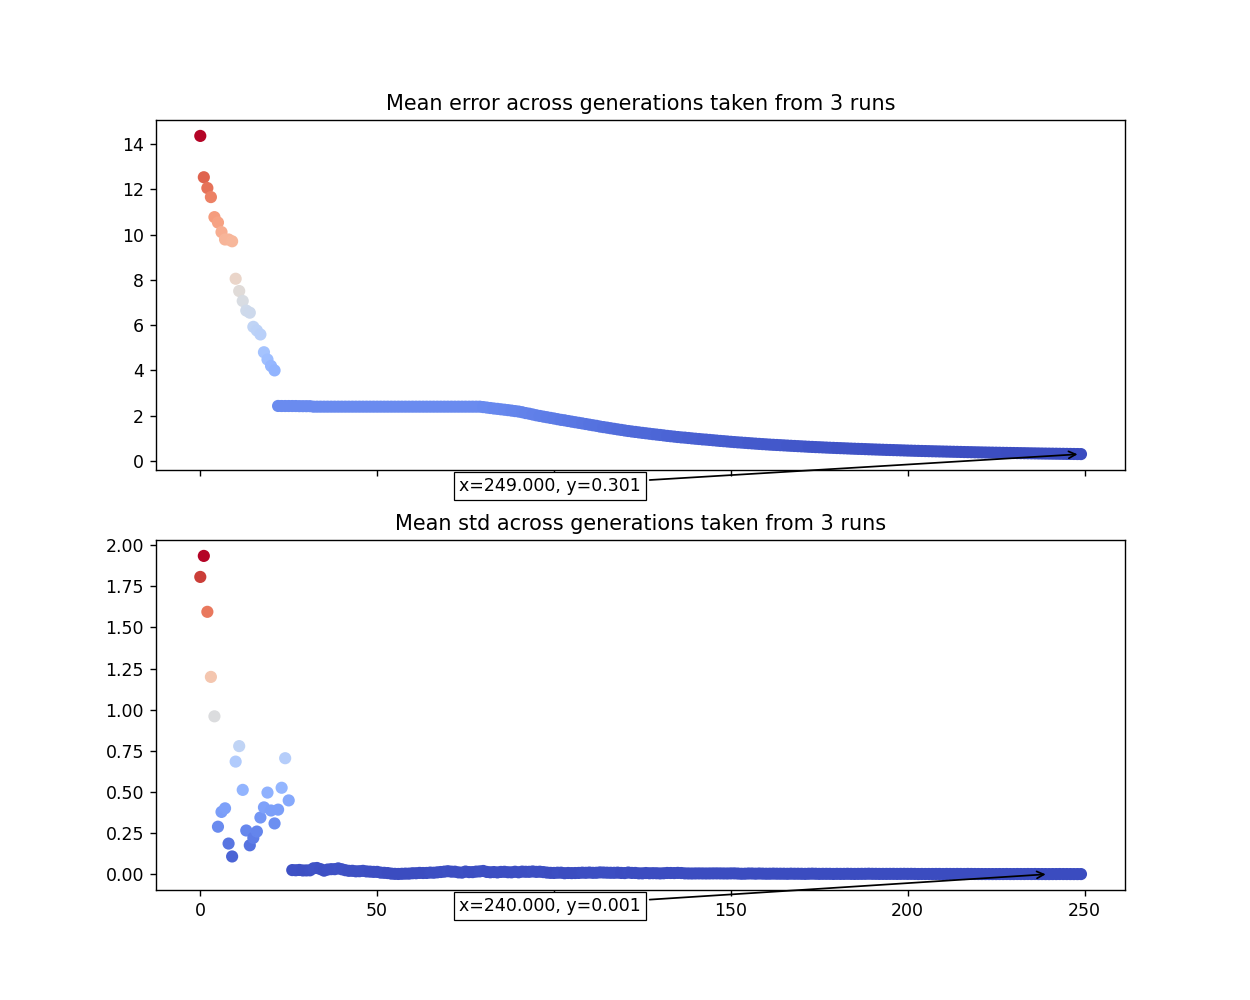

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
BOA,-15,30,ackley,0.729844,BOA,2.05,0.8,nuvd,3,1,30,1,0.5,0.01,0.997061


--- Mean computation time 0.5083 seconds ---
--- Mean solution 0.7471 ---
--- Mean std 0.1037 ---


<IPython.core.display.Javascript object>


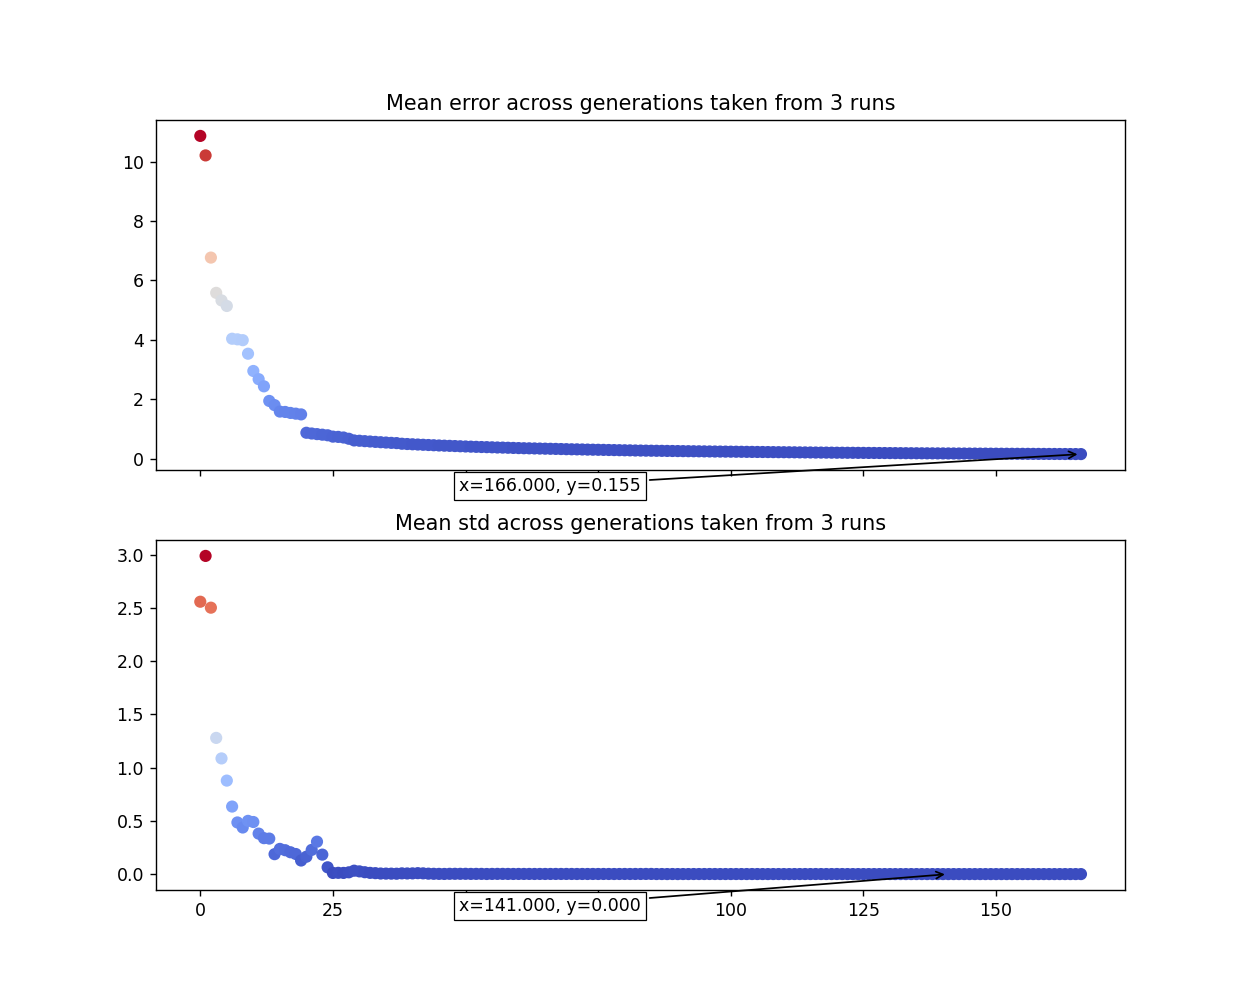

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
BOA,-15,30,ackley,0.729844,BOA,2.05,0.8,nuvd,3,1,50,1,0.5,0.01,1.36062


--- Mean computation time 0.4760 seconds ---
--- Mean solution 0.6766 ---
--- Mean std 0.1562 ---


<IPython.core.display.Javascript object>


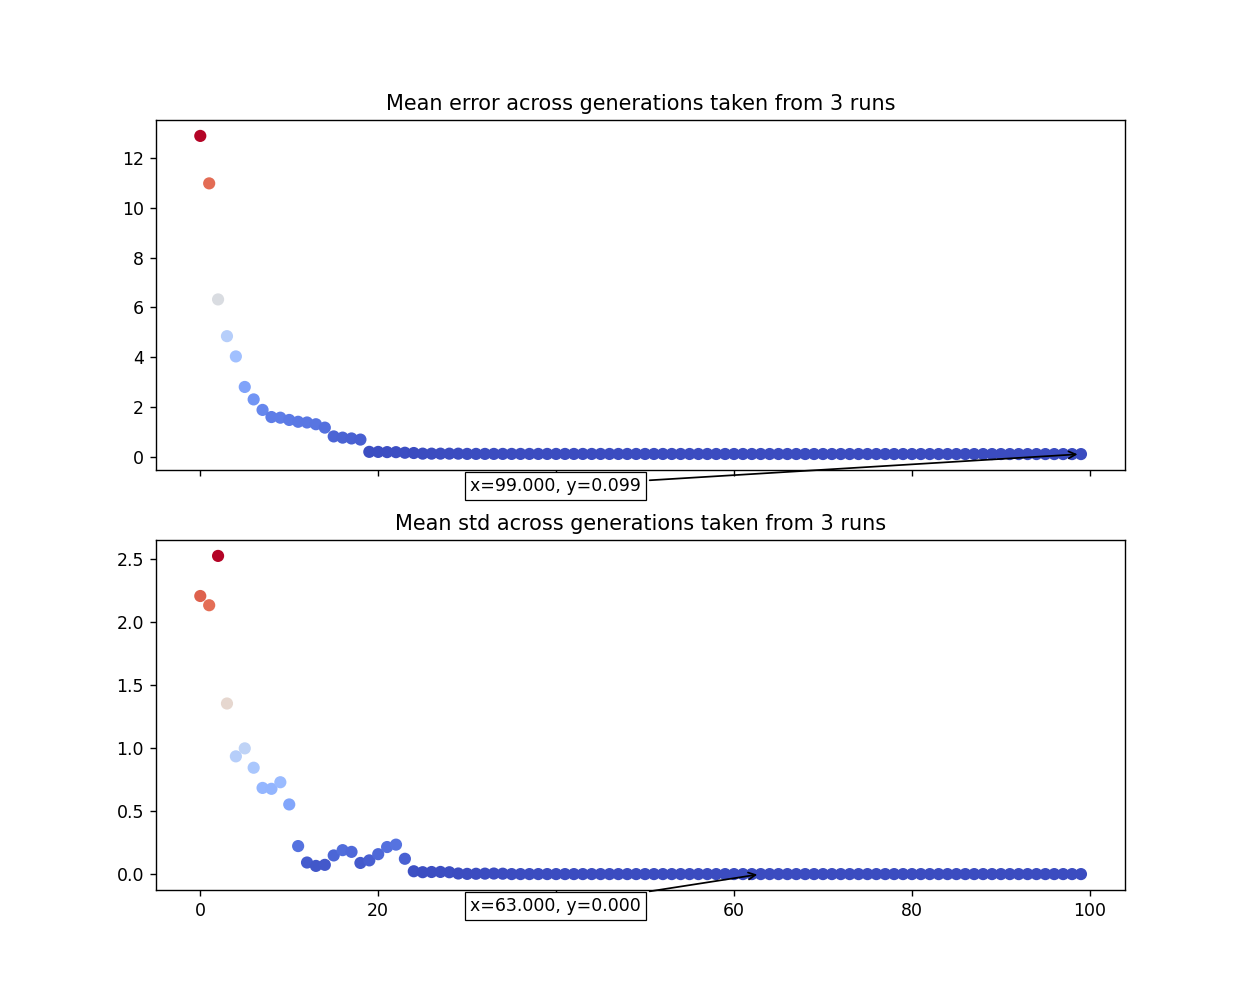

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
MPSO,-15,30,ackley,0.729844,MPSO,2.05,0.8,nuvd,3,1,20,1,0.5,0.01,0.1


--- Mean computation time 0.4806 seconds ---
--- Mean solution 1.7276 ---
--- Mean std 0.9739 ---


<IPython.core.display.Javascript object>


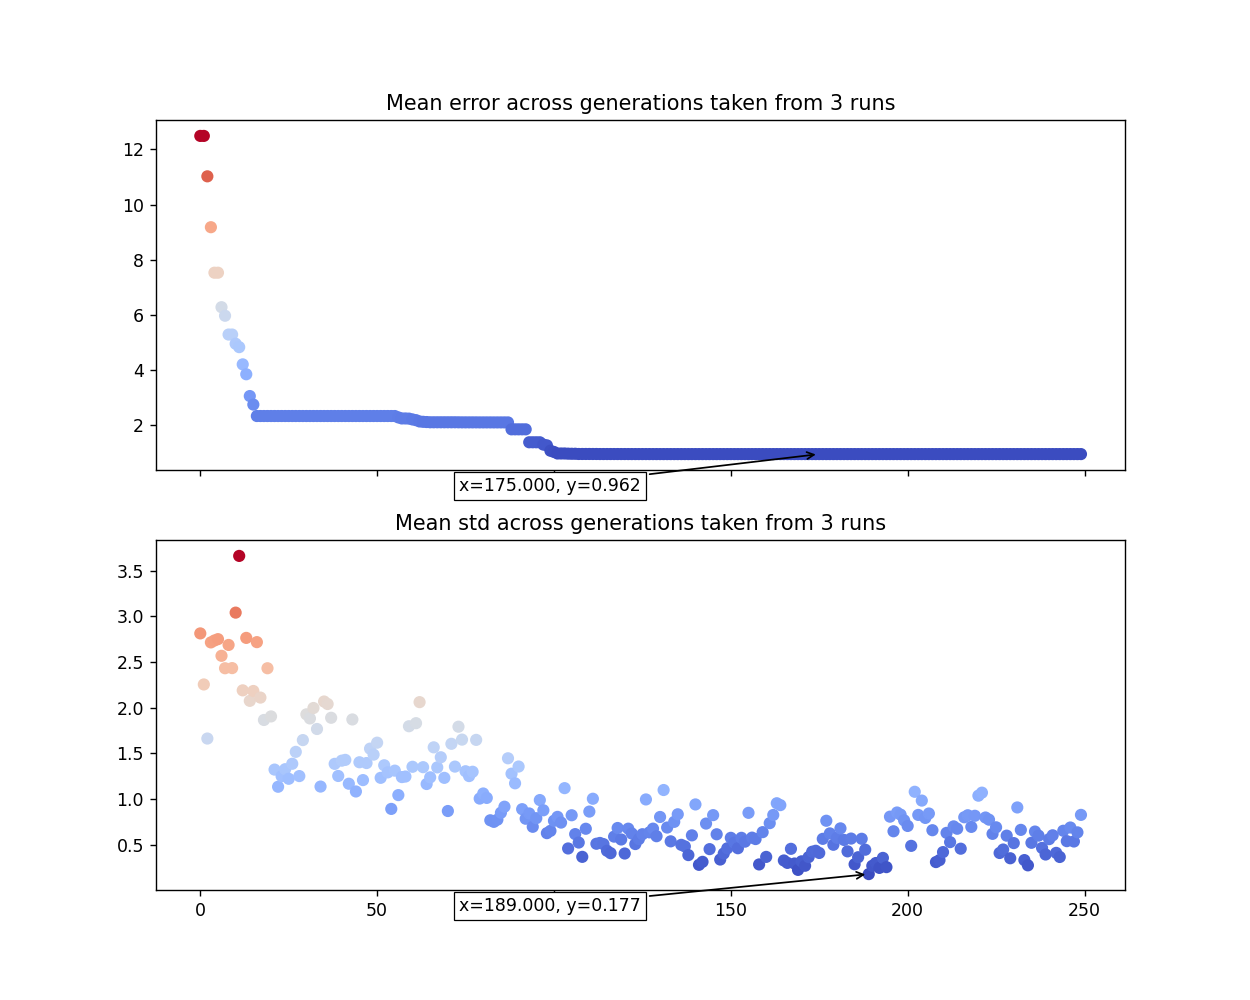

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
MPSO,-15,30,ackley,0.729844,MPSO,2.05,0.8,nuvd,3,1,30,1,0.5,0.01,0.1


--- Mean computation time 0.4376 seconds ---
--- Mean solution 0.6816 ---
--- Mean std 0.4103 ---


<IPython.core.display.Javascript object>


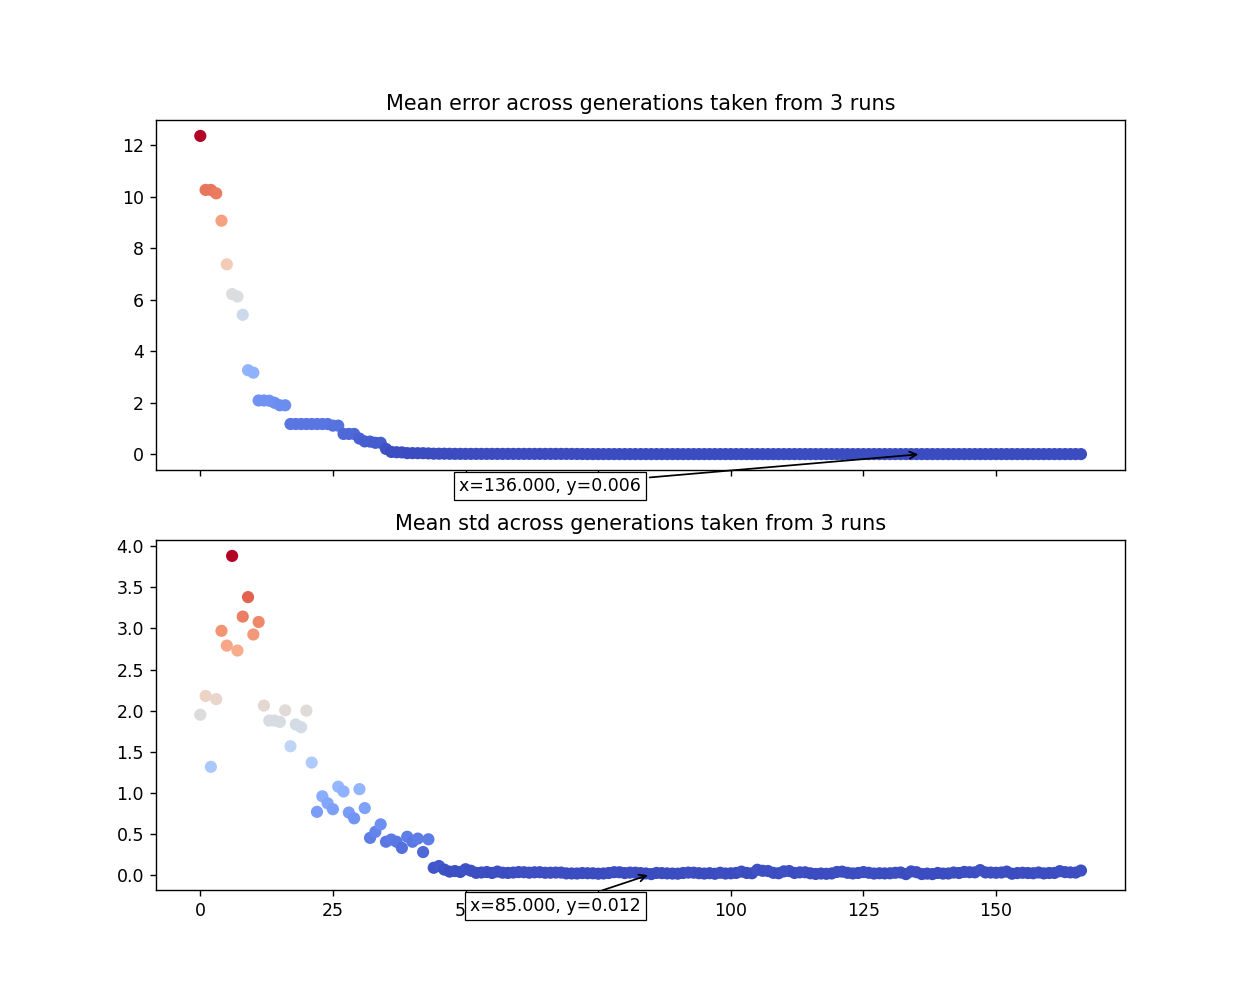

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
MPSO,-15,30,ackley,0.729844,MPSO,2.05,0.8,nuvd,3,1,50,1,0.5,0.01,0.1


--- Mean computation time 0.4384 seconds ---
--- Mean solution 0.8580 ---
--- Mean std 0.6083 ---


<IPython.core.display.Javascript object>


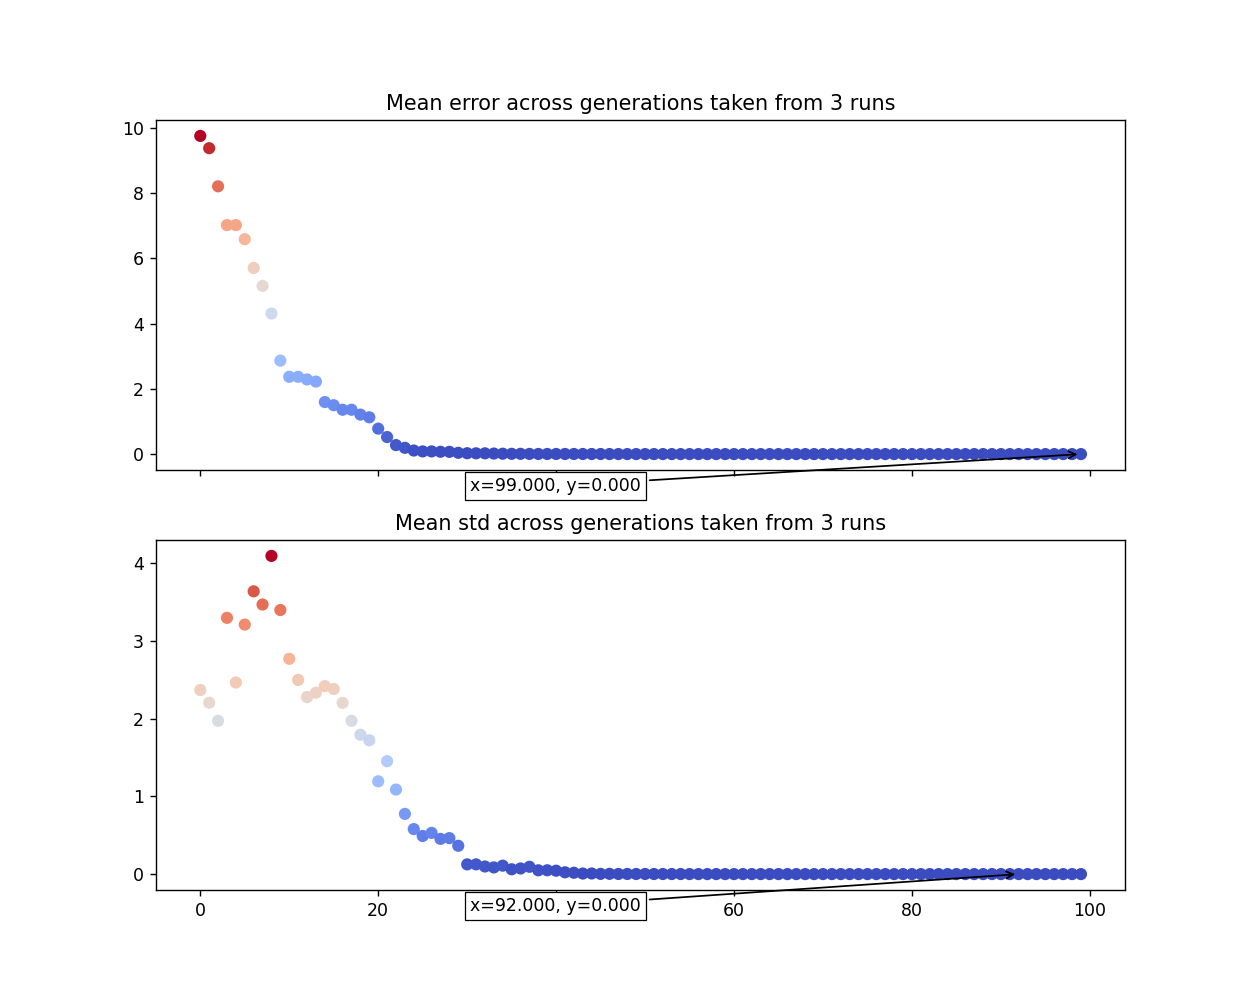

In [219]:
cfg = load_config()
cfg.TYPE = "BOA"
cfg.NPARTICLES = 20
run_n_times(n_runs, "NPARTICLES")
cfg.NPARTICLES = 30
run_n_times(n_runs, "NPARTICLES")
cfg.NPARTICLES = 50
run_n_times(n_runs, "NPARTICLES")

cfg = load_config()
cfg.TYPE = "MPSO"
cfg.NPARTICLES = 20
run_n_times(n_runs, "NPARTICLES")
cfg.NPARTICLES = 30
run_n_times(n_runs, "NPARTICLES")
cfg.NPARTICLES = 50
run_n_times(n_runs, "NPARTICLES")

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
BOA,-15,30,ackley,0.729844,BOA,2.05,0.8,nuvd,20,1,30,1,0.5,0.01,0.1


--- Mean computation time 0.9902 seconds ---
--- Mean solution 2.9314 ---
--- Mean std 0.0930 ---


<IPython.core.display.Javascript object>


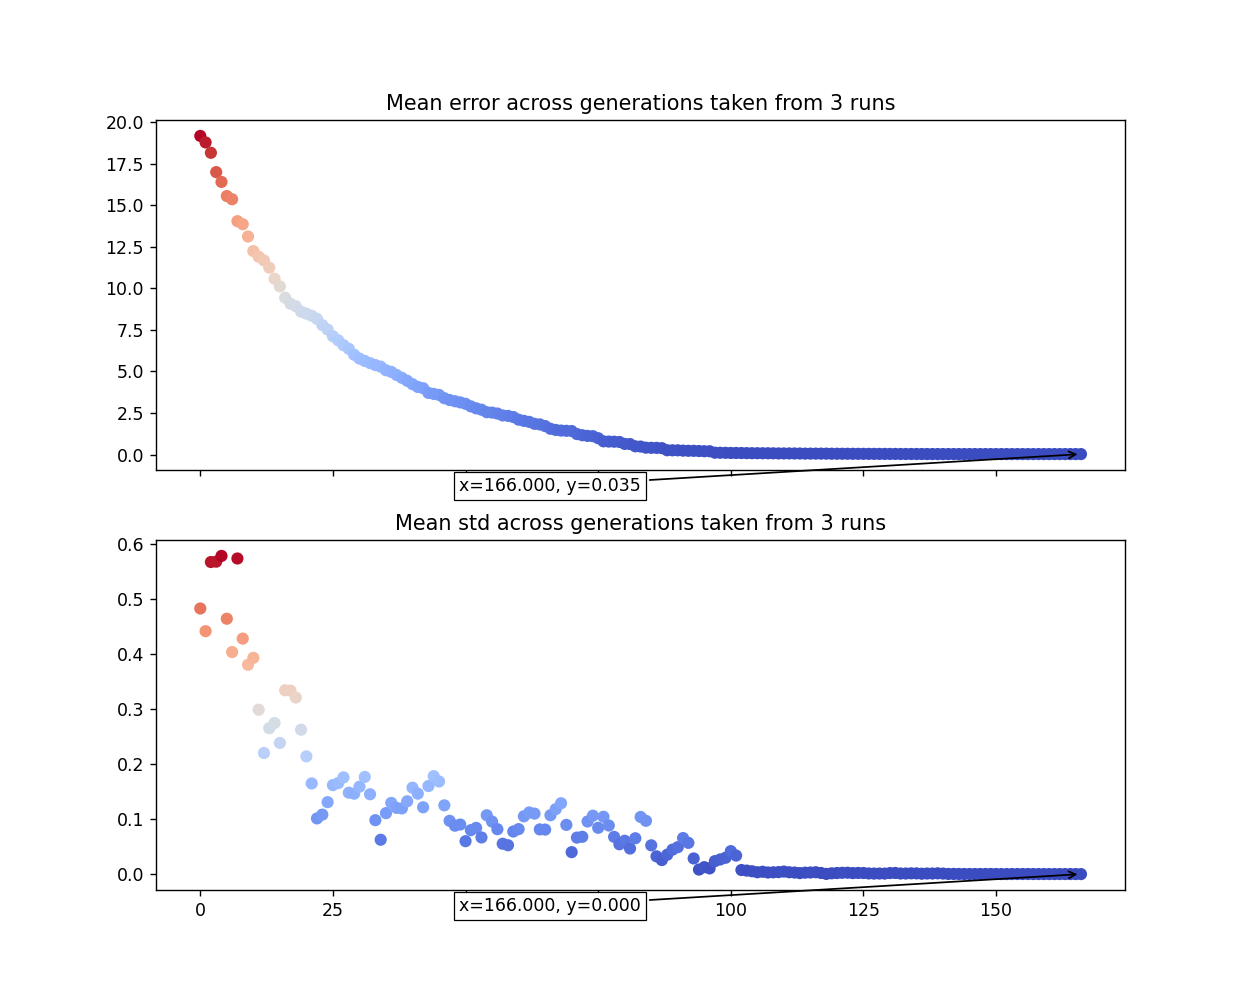

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
BOA,-15,30,ackley,0.729844,BOA,2.05,0.8,nuvd,30,1,30,1,0.5,0.01,0.96642


--- Mean computation time 1.2586 seconds ---
--- Mean solution 1.8678 ---
--- Mean std 0.0655 ---


<IPython.core.display.Javascript object>


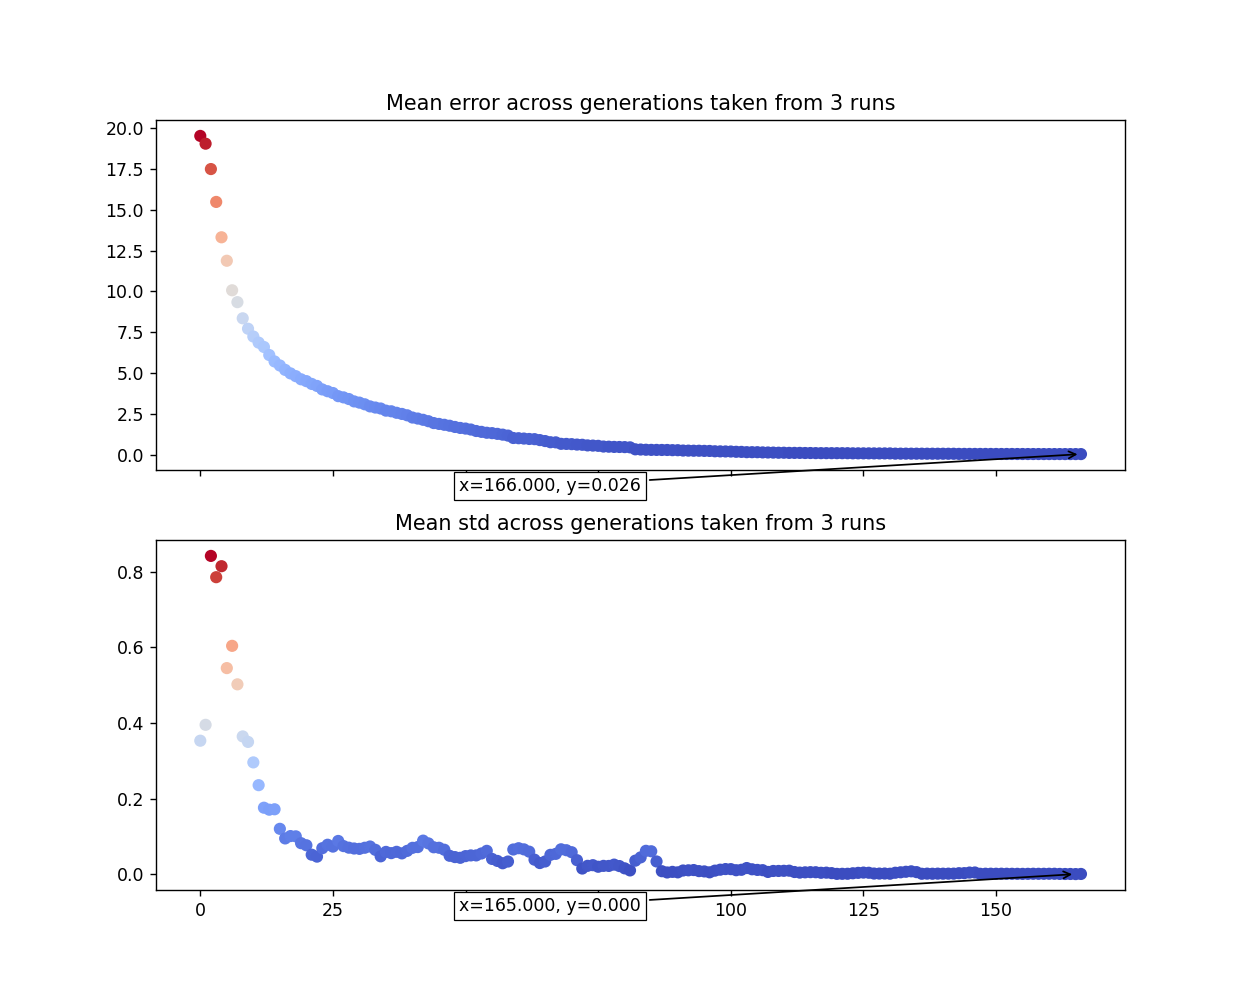

In [217]:
cfg = load_config()
cfg.TYPE = "BOA"
cfg.NPARTICLES = 30
cfg.DIMS = 20
run_n_times(n_runs, "DIMS")
cfg.DIMS = 30
run_n_times(n_runs, "DIMS")

cfg = load_config()
cfg.TYPE = "MPSO"
cfg.NPARTICLES = 30
cfg.DIMS = 20
run_n_times(n_runs, "DIMS")
cfg.DIMS = 30
run_n_times(n_runs, "DIMS")

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
BOA,-15,30,griewank,0.729844,BOA,2.05,0.8,nuvd,3,1,20,1,0.5,0.01,0.1


--- Mean computation time 0.5799 seconds ---
--- Mean solution 0.1461 ---
--- Mean std 0.0747 ---


<IPython.core.display.Javascript object>


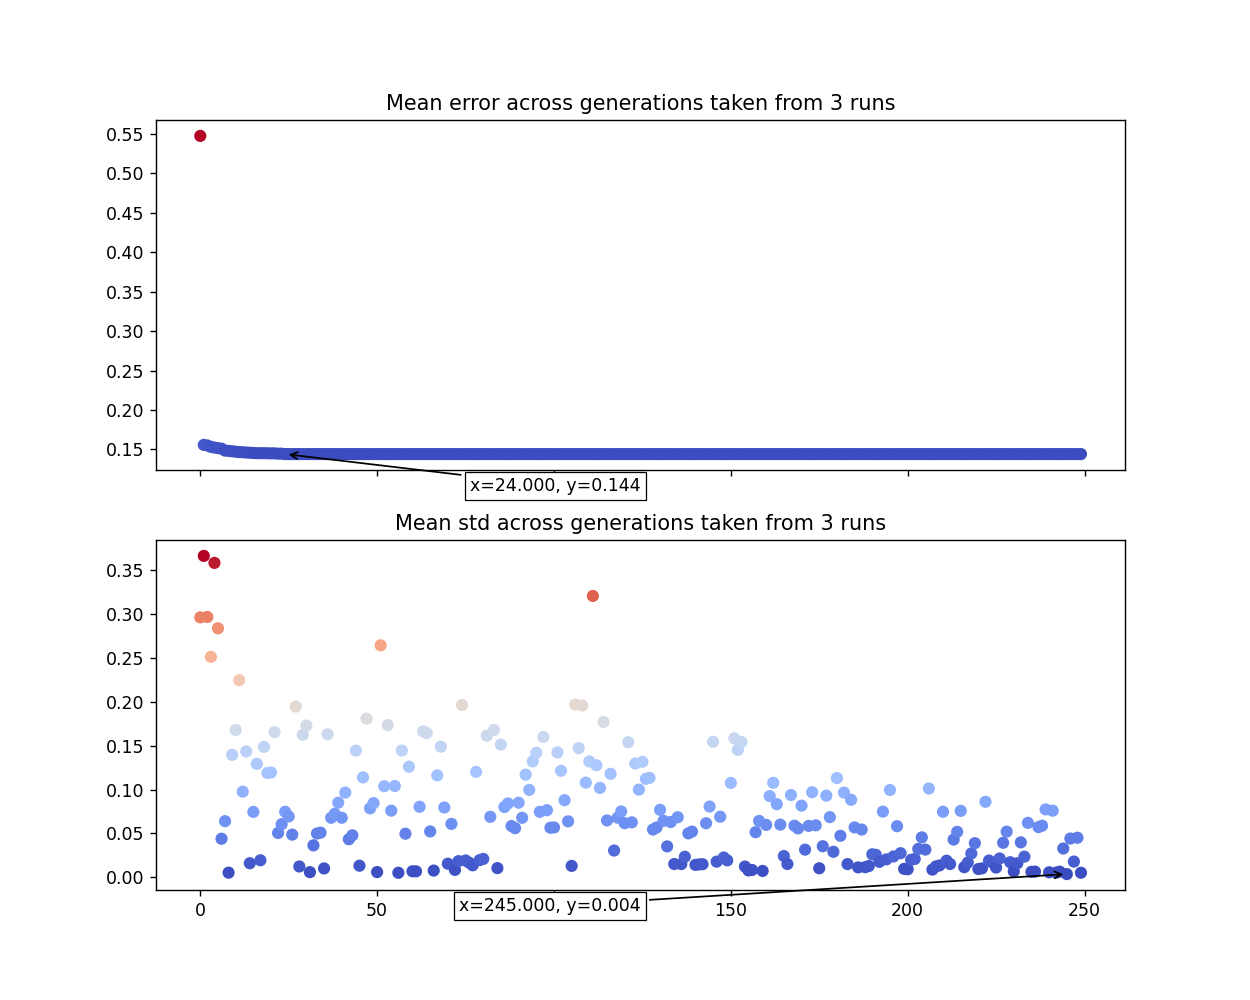

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
BOA,-15,30,ackley,0.729844,BOA,2.05,0.8,nuvd,3,1,20,1,0.5,0.01,0.997061


--- Mean computation time 0.6644 seconds ---
--- Mean solution 1.3656 ---
--- Mean std 0.0543 ---


<IPython.core.display.Javascript object>


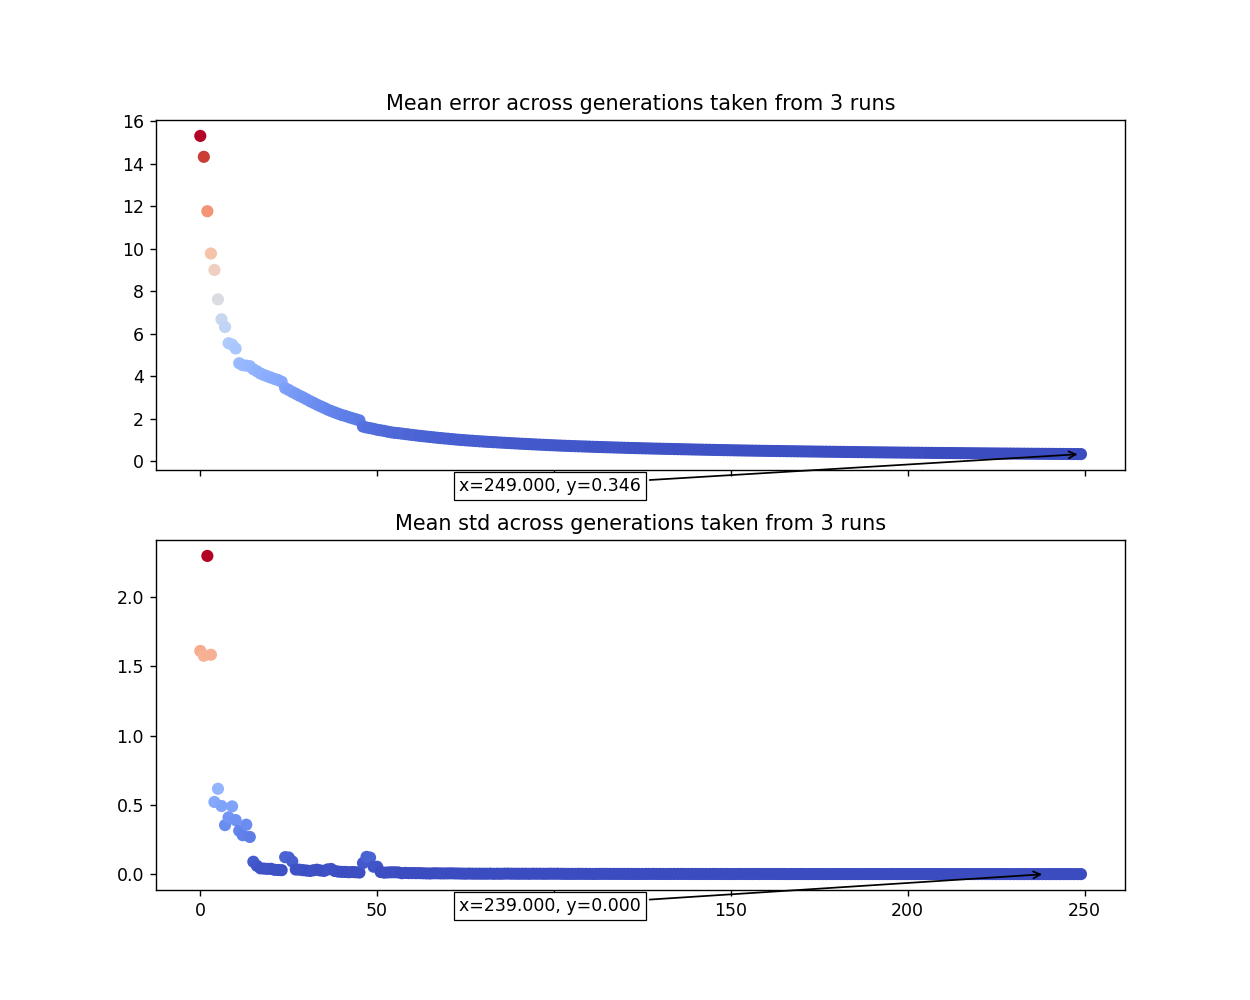

In [218]:
cfg = load_config()
cfg.TYPE = "BOA"
cfg.FUNCTION = "griewank"
run_n_times(n_runs, "griewank")
cfg.FUNCTION = "ackley"
run_n_times(n_runs, "ackley")

cfg = load_config()
cfg.TYPE = "MPSO"
cfg.FUNCTION = "griewank"
run_n_times(n_runs, "griewank")
cfg.FUNCTION = "ackley"
run_n_times(n_runs, "ackley")